https://github.com/nv-nguyen/gigaPose
inspired by gigapose

In [3]:
# Create 3d model from image
import argparse
import logging
import os
import time

import numpy as np
import rembg
import torch
from PIL import Image

from tsr.system import TSR
from tsr.utils import remove_background, resize_foreground, save_video

class Timer:
    def __init__(self):
        self.items = {}
        self.time_scale = 1000.0  # ms
        self.time_unit = "ms"

    def start(self, name: str) -> None:
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        self.items[name] = time.time()
        logging.info(f"{name} ...")

    def end(self, name: str) -> float:
        if name not in self.items:
            return
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = self.items.pop(name)
        delta = time.time() - start_time
        t = delta * self.time_scale
        logging.info(f"{name} finished in {t:.2f}{self.time_unit}.")


timer = Timer()

def process_images(image_paths, device="cuda:0", pretrained_model_name_or_path="stabilityai/TripoSR", chunk_size=8192, mc_resolution=256, no_remove_bg=False, foreground_ratio=0.85, output_dir="output/", model_save_format="obj", render=False):
    timer = Timer()

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(message)s", level=logging.INFO
    )

    print(locals())

    os.makedirs(output_dir, exist_ok=True)

    if torch.cuda.is_available():
        device = "cuda:0"
    # elif torch.backends.mps.is_available():
    #     device = "mps"
    else:
        device = "cpu"

    timer.start("Initializing model")
    model = TSR.from_pretrained(
        pretrained_model_name_or_path,
        config_name="config.yaml",
        weight_name="model.ckpt",
    )
    model.renderer.set_chunk_size(chunk_size)
    model.to(device)
    timer.end("Initializing model")

    timer.start("Processing images")
    images = []

    if no_remove_bg:
        rembg_session = None
    else:
        rembg_session = rembg.new_session()

    for i, image_path in enumerate(image_paths):
        image_hash = image_paths[i].split("/")[-2]

        if no_remove_bg:
            image = np.array(Image.open(image_path).convert("RGB"))
        else:
            image = remove_background(Image.open(image_path), rembg_session)
            image = resize_foreground(image, foreground_ratio)[0]
            image = np.array(image).astype(np.float32) / 255.0
            image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
            image = Image.fromarray((image * 255.0).astype(np.uint8))
            if not os.path.exists(os.path.join(output_dir, image_hash)):
                os.makedirs(os.path.join(output_dir, image_hash))
            image.save(os.path.join(output_dir,image_hash, f"input.png"))
        images.append(image)
    timer.end("Processing images")

    for i, image in enumerate(images):
        image_hash = image_paths[i].split("/")[-2]

        logging.info(f"Running image {i + 1}/{len(images)} ...")

        timer.start("Running model")
        with torch.no_grad():
            scene_codes = model([image], device=device)
        timer.end("Running model")

        if render:
            timer.start("Rendering")
            render_images = model.render(scene_codes, n_views=30, return_type="pil")
            for ri, render_image in enumerate(render_images[0]):
                render_image.save(os.path.join(output_dir, image_hash, f"render_{ri:03d}.png"))
            save_video(
                render_images[0], os.path.join(output_dir, image_hash, f"render.mp4"), fps=30
            )
            timer.end("Rendering")

        timer.start("Exporting mesh")
        meshes = model.extract_mesh(scene_codes, resolution=mc_resolution)
        meshes[0].export(os.path.join(output_dir, image_hash, f"mesh.{model_save_format}"))
        timer.end("Exporting mesh")

/opt/homebrew/anaconda3/envs/space/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create image from 3d model
import argparse
import ObjFile
import sys
import os
import glob

def convert_obj_to_png(objfiles, outfile=None, azim=None, elevation=None, quality=None, resolution=None, scale=None, view=False, animate=False):
    res = {"HIGH": 1200, "MEDIUM": 600, "LOW": 300}
    dpi = None
    if quality:
        if type(quality) == int:
            dpi = quality
        elif quality.upper() in res:
            dpi = res[quality.upper()]

    width = dpi
    height = dpi
    if resolution:
        width, height = resolution.split("x")
        width = int(width)
        height = int(height)

    for objfile in objfiles:
        if os.path.isfile(objfile) and ".obj" in objfile:
            out_file = objfile.replace(".obj", ".png")
            if outfile:
                out_file = outfile
                print(out_file)

            if view:
                out_file = None
            else:
                print("Converting %s to %s" % (objfile, out_file))
            ob = ObjFile.ObjFile(objfile)
            ob.Plot(
                out_file,
                elevation=elevation,
                azim=azim,
                width=width,
                height=height,
                scale=scale,
                animate=animate,
            )
        
        else:
            print("File %s not found or not file type .obj" % objfile)
            sys.exit(1)

In [13]:
# create a series of images from 360 degrees horizontally and vertically each 30 degrees apart
def render_mesh_images(start_azim=-180, end_azim=180, step_azim=30, start_elev=-90, end_elev=90, step_elev=30, obj_file_path="output/0/mesh.obj", output_dir="output/0/", quality="LOW"):
    for i in range(start_azim, end_azim, step_azim):
        for j in range(start_elev, end_elev, step_elev):
            outfile = f"{output_dir}mesh_{i}_{j}.png"
            convert_obj_to_png([obj_file_path], outfile=outfile, azim=i, elevation=j, quality=quality)

# rotate all the images generated
from torchvision.transforms import v2
def render_rotations(input_dir="output/0/", output_dir="output/0/"):
    for infile in glob.glob(f"{input_dir}mesh*.png"):
        image = Image.open(infile)
        for i in range(0, 360, 10):
            outfile = f"{output_dir}{os.path.basename(infile).replace('.png', f'_{i}.png')}"
            image = v2.functional.rotate(image, i)
            image.save(outfile)
        # delete original file
        os.remove(infile)


# for i in range(0, 360, 30):
#     for j in range(-90, 90, 30):
#         # print("Rendering %s %s" % (i, j))
#         convert_obj_to_png(["output/0/mesh.obj"], outfile="output/0/mesh_%s_%s.png" % (i, j), azim=i, elevation=j, quality="LOW")


In [6]:
# compare a given image against the generated images to see which is the closest match
# this is done by comparing the generated image against the given image using the MSE (Mean Squared Error) method
import cv2
import numpy as np
from pytorch_msssim import ssim, SSIM

from skimage.metrics import mean_squared_error
def compare_images(original, generated_img, cropping_matrix, constant=100):
    if type(original) == str:
        img1 = mpimg.imread(original)
    else:
        img1 = original
    if type(generated_img) == str:
        img2 = mpimg.imread(generated_img)
    else:
        img2 = generated_img

    img1 = img1[int(cropping_matrix[0][1]):int(cropping_matrix[1][1]), int(cropping_matrix[0][0]):int(cropping_matrix[1][0])]

    
    # convert best_image into same aspect ratio as img by croppping
    aspect_ratio = img1.shape[1] / img1.shape[0]
    # reshape so that longest edge is 300
    if img1.shape[0] < img1.shape[1]:
        img1 = cv2.resize(img1, (300, int(300 / aspect_ratio)))
    else:
        img1 = cv2.resize(img1, (int(300 * aspect_ratio), 300))
    img1_gray = img1
    if aspect_ratio > 1:
        desired_width = img2.shape[1]
        desired_height = int(img2.shape[0] / aspect_ratio)
    else:
        desired_width = int(img2.shape[1] * aspect_ratio)
        desired_height = img2.shape[0]

    crop_x = (img2.shape[1] - desired_width) // 2
    crop_y = (img2.shape[0] - desired_height) // 2
    
    img2_cropped = img2[crop_y:crop_y+desired_height, crop_x:crop_x+desired_width]
    img2 = img2_cropped
    # remove alpha channel
    img2 = img2[:, :, :3]
    # clamp all values to be either 0 or 1 for both images

    # convert to greyscale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # normalize to 0-255
    img1 = cv2.normalize(img1, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # run adaptive thresholding on both images
    # img1 = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, constant)
    # img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, constant)

    # run normal thresholding
    threshold = np.mean(img1)

    img1 = cv2.threshold(img1, threshold, 255, cv2.THRESH_BINARY)[1]
    img2 = cv2.threshold(img2, threshold, 255, cv2.THRESH_BINARY_INV)[1]
    # print(img1.shape)
    # print(img2.shape)

    # run high pass filter on both images
    # kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # laplacian kernel
    # kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # prewitt kernel

    # img1_gray = cv2.filter2D(img1_gray, -1, kernel)
    # img2_gray = cv2.filter2D(img2_gray, -1, kernel)
    loss = mean_squared_error(img1, img2)

    # Assume input_img and target_img are your input and target images
    # ssim_mod = SSIM(size_average=True, data_range=255, channel=3)
    # reshape to 5 dimensions
    # img1 = img1[np.newaxis, np.newaxis, :, :]
    # img2 = img2[np.newaxis, np.newaxis, :, :]
    # print(img1.shape)
    # print(img2.shape)

    # loss = 1- ssim(img1, img2, size_average=True)
    # print("Loss:", loss)
    # diff = np.abs(img1_gray - img2_gray) 
    return loss

In [7]:
# remove background from original image

def remove_background_and_get_cropping_matrix(image_paths, device="cuda:0", rembg_session=None, pretrained_model_name_or_path="stabilityai/TripoSR", chunk_size=8192, mc_resolution=256, no_remove_bg=False, foreground_ratio=0.85, output_dir="output/", model_save_format="obj", render=False):
    os.makedirs(output_dir, exist_ok=True)

    if rembg_session is None:
        rembg_session = rembg.new_session()

    for i, image_path in enumerate(image_paths):
        image_hash = image_paths[i].split("/")[-2]
        image = remove_background(Image.open(image_path), rembg_session)
        # print(type(resize_foreground(image, foreground_ratio)))

        image, cropping_matrix = resize_foreground(image, foreground_ratio)
        # print(cropping_matrix)
        image = np.array(image).astype(np.float32) / 255.0
        image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
        image = Image.fromarray((image * 255.0).astype(np.uint8))
        if not os.path.exists(os.path.join(output_dir, image_hash)):
            os.makedirs(os.path.join(output_dir, image_hash))
        image.save(os.path.join(output_dir, image_hash, f"removed_background.png"))
    return cropping_matrix

# overload with a way to use np array as image
def remove_background_and_get_cropping_matrix_np(image, device="cuda:0", rembg_session=None, pretrained_model_name_or_path="stabilityai/TripoSR", chunk_size=8192, mc_resolution=256, no_remove_bg=False, foreground_ratio=0.85, output_dir="output/", model_save_format="obj", render=False):
    os.makedirs(output_dir, exist_ok=True)

    if rembg_session is None:
        rembg_session = rembg.new_session()

    image = rembg.remove(image, rembg_session)
    # print(type(resize_foreground(image, foreground_ratio)))

    image, cropping_matrix = resize_foreground(image, foreground_ratio)
    # print(cropping_matrix)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[:, :, :3] * image[:, :, 3:4] + (1 - image[:, :, 3:4]) * 0.5
    image = Image.fromarray((image * 255.0).astype(np.uint8))
    if not os.path.exists(os.path.join(output_dir)):
        os.makedirs(os.path.join(output_dir))
    image.save(os.path.join(output_dir, f"removed_background.png"))
    return cropping_matrix

In [14]:
# run
image = "data/images/0d3a985c84/000.png"
image_hash = image.split("/")[-2]
cropping_matrix = remove_background_and_get_cropping_matrix([image], output_dir="output", foreground_ratio=0.85)
process_images([image], output_dir="output", foreground_ratio=0.85)
render_mesh_images(obj_file_path=f"output/{image_hash}/mesh.obj", output_dir=f"output/{image_hash}/", quality="LOW")
render_rotations(input_dir=f"output/{image_hash}/", output_dir=f"output/{image_hash}/")


2024-04-19 17:57:41,120 - INFO - Initializing model ...


{'image_paths': ['data/images/0d3a985c84/000.png'], 'device': 'cuda:0', 'pretrained_model_name_or_path': 'stabilityai/TripoSR', 'chunk_size': 8192, 'mc_resolution': 256, 'no_remove_bg': False, 'foreground_ratio': 0.85, 'output_dir': 'output', 'model_save_format': 'obj', 'render': False, 'timer': <__main__.Timer object at 0x3411a8ca0>}


/opt/homebrew/anaconda3/envs/space/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2024-04-19 17:57:46,335 - INFO - Initializing model finished in 5214.56ms.
2024-04-19 17:57:46,345 - INFO - Processing images ...
2024-04-19 17:57:56,508 - INFO - Processing images finished in 10163.19ms.
2024-04-19 17:57:56,509 - INFO - Running image 1/1 ...
2024-04-19 17:57:56,509 - INFO - Running model ...
2024-04-19 17:58:00,888 - INFO - Running model finished in 4379.36ms.
2024-04-19 17:58:00,889 - INFO - Exporting mesh ...
2024-04-19 17:58:16,417 - INFO - Exporting mesh finished in 15527.95ms.


output/0d3a985c84/mesh_-180_-90.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-180_-90.png
output/0d3a985c84/mesh_-180_-60.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-180_-60.png
output/0d3a985c84/mesh_-180_-30.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-180_-30.png
output/0d3a985c84/mesh_-180_0.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-180_0.png
output/0d3a985c84/mesh_-180_30.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-180_30.png
output/0d3a985c84/mesh_-180_60.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-180_60.png
output/0d3a985c84/mesh_-150_-90.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-150_-90.png
output/0d3a985c84/mesh_-150_-60.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-150_-60.png
output/0d3a985c84/mesh_-150_-30.png
Converting output/0d3a985c84/mesh.obj to output/0d3a985c84/mesh_-150

-180/180
-150/180
-120/180
-90/180
-60/180
-30/180
0/180
30/180
60/180
90/180
120/180
150/180
Best image output/0d3a985c84/mesh_-180_30_0.png MSE:  18497.557112068964
(232, 300)


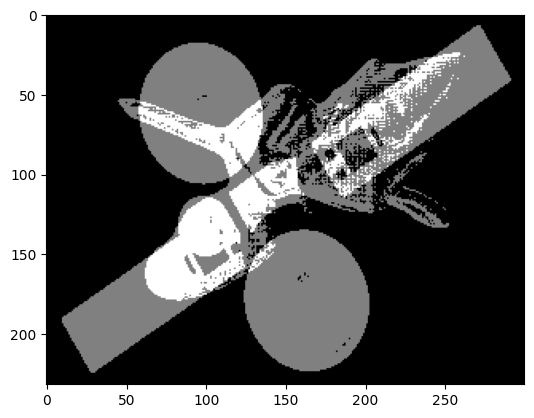

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
best_mse = 1000000
best_image = ""
constant = 5
to_compare = "data/images/0d3a985c84/010.png"
image_hash = to_compare.split("/")[-2]
cropping_matrix = remove_background_and_get_cropping_matrix([to_compare], output_dir="output", foreground_ratio=0.85)
for i in range(-180, 180, 30):
    for j in range(-90, 90, 30):
        for k in range(0, 360, 10):
            # print("Rendering %s %s" % (i, j))
            mse = compare_images(to_compare, f"output/{image_hash}/mesh_{i}_{j}_{k}.png", cropping_matrix, constant=constant)
            if mse < best_mse:
                best_mse = mse
                best_image = f"output/{image_hash}/mesh_{i}_{j}_{k}.png"
            # print("MSE value for %s %s %s: %s" % (i, j, k, mse))
    print(f"{i}/{180}")

print("Best image", (best_image), "MSE: ", best_mse)


#  plot the best image over the removed background image all in greyscale

img = mpimg.imread(to_compare)
# crop image based on cropping matrix with a 
img = img[int(cropping_matrix[0][1]):int(cropping_matrix[1][1]), int(cropping_matrix[0][0]):int(cropping_matrix[1][0])]

# convert to greyscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert best_image into same aspect ratio as img by croppping
aspect_ratio = img.shape[1] / img.shape[0]
# reshape so that longest edge is 300
if img.shape[0] < img.shape[1]:
    img = cv2.resize(img, (300, int(300 / aspect_ratio)))
else:
    img = cv2.resize(img, (int(300 * aspect_ratio), 300))
print(img.shape)


# use this aspect ratio to crop the img2
# Calculate the desired width and height based on the aspect ratio
# Calculate the cropping coordinates
img2 = mpimg.imread(best_image)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
img2 = cv2.normalize(img2, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# make threshold  the mean value
threshold = np.mean(img)
img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)[1]
img2 = cv2.threshold(img2, threshold, 255, cv2.THRESH_BINARY_INV)[1]
# img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, constant)
# img2 = cv2.adaptiveThreshold(img2, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, constant)

# get desired width and height
if aspect_ratio > 1:
    desired_width = img2.shape[1]
    desired_height = int(img2.shape[0] / aspect_ratio)
else:
    desired_width = int(img2.shape[1] * aspect_ratio)
    desired_height = img2.shape[0]
# print("Aspect ratio:", aspect_ratio)
# print("Desired width:", desired_width, "Desired height:", desired_height)

crop_x = (img2.shape[1] - desired_width) // 2
crop_y = (img2.shape[0] - desired_height) // 2
# print("Crop x:", crop_x, "Crop y:", crop_y)

# Crop img2
img2_cropped = img2[crop_y:crop_y+desired_height, crop_x:crop_x+desired_width]


# img2_cropped = cv2.cvtColor(img2_cropped, cv2.COLOR_BGR2GRAY)
 # run high pass filter on both images
# kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) # laplacian kernel
# kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]) # prewitt kernel
# img = cv2.filter2D(img, -1, kernel)
# img2_cropped = cv2.filter2D(img2_cropped, -1, kernel)
plt.imshow(img, cmap='gray')

plt.imshow(img2_cropped, cmap='gray', alpha=0.5)
plt.show()

In [ ]:
# create dataset from train_labels.csv

import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import io
from skimage import io, transform
import random
# create dataset that contains the image label and data label
class SpacecraftPoseDataset(Dataset):
    """ Spacecraft pose dataset """

    def __init__(self, csv_file=None, root_dir=None, df=None, transform = None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        if df is not None:
            self.labels_frame = df
        else:
            self.labels_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        img_name = os.path.join(self.root_dir, self.labels_frame.iloc[idx, 0], f'{self.labels_frame.iloc[idx, 1]:03}.png')
        image = io.imread(img_name)
        label = self.labels_frame.iloc[idx, 1:]
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

df = pd.read_csv('data/train_labels.csv')
# split df by chain_id
spacecraft = []
# print(df.head())
for chain_id in df['chain_id'].unique():
    spacecraft.append(df[df['chain_id'] == chain_id])

# print(spacecraft)
for i in range(len(spacecraft)):
    spacecraft[i] = SpacecraftPoseDataset(df=spacecraft[i], root_dir='data/images')

print("num of spacecraft:",len(spacecraft))
print(spacecraft[0].labels_frame)

num of spacecraft: 660
      chain_id   i         x          y          z        qw        qx  \
0   0036465cc6   0  0.000000   0.000000   0.000000  1.000000  0.000000   
1   0036465cc6   1  0.571732   8.856913 -11.087827  0.996956 -0.046685   
2   0036465cc6   2 -0.014641   2.789255  -5.214775  0.988523 -0.149369   
3   0036465cc6   3  0.585297  -3.229511   6.535775  0.967863 -0.249140   
4   0036465cc6   4  0.001839  -5.679097  -0.621195  0.927903 -0.371874   
..         ...  ..       ...        ...        ...       ...       ...   
95  0036465cc6  95  9.179001  -1.624819  46.294876  0.816051 -0.541895   
96  0036465cc6  96  4.739944 -12.634557  33.057953  0.763408 -0.627469   
97  0036465cc6  97  4.580025 -13.378366  34.722820  0.699370 -0.696213   
98  0036465cc6  98  5.236244 -13.200182  37.596085  0.622183 -0.763400   
99  0036465cc6  99  7.267212  -2.460377  44.878868  0.511466 -0.836587   

          qy        qz  
0   0.000000  0.000000  
1  -0.046640 -0.041523  
2  -0.017915 

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch
import torchvision.transforms as transforms

class LinearModel_BaseCroppingMatrix_NewCroppingMatrix_Azimuth_Elevation(nn.Module):
    def __init__(self):
        super(LinearModel_BaseCroppingMatrix_NewCroppingMatrix_Azimuth_Elevation, self).__init__()
        self.fc1 = nn.Linear(10, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create an instance of the model
model = LinearModel_BaseCroppingMatrix_NewCroppingMatrix_Azimuth_Elevation()

In [34]:
def get_azimuth_elevation(to_compare, image_hash, constant=5):
    best_mse = 1000000
    best_image = ""
    best_i = 0
    best_j = 0
    
    for i in range(-180, 180, 30):
        for j in range(-90, 90, 30):
            mse = compare_images(to_compare, f"output/{image_hash}/mesh_{i}_{j}.png", cropping_matrix, constant=constant)
            if mse < best_mse:
                best_mse = mse
                best_image = f"output/{image_hash}/mesh_{i}_{j}.png"
                best_i = i
                best_j = j
    return [best_i, best_j]


In [2]:
# train the model

for i in spacecraft:
    # if this folder does not exist in output, create it
    if not os.path.exists(f"output/{i.labels_frame['chain_id'][0]}"):
        image_hash = i.labels_frame['chain_id'][0]
        image = f"data/images/{image_hash}/000.png"
        cropping_matrix = remove_background_and_get_cropping_matrix([image], output_dir="output", foreground_ratio=0.85)
        process_images([image], output_dir="output", foreground_ratio=0.85)
        render_mesh_images(obj_file_path=f"output/{image_hash}/mesh.obj", output_dir=f"output/{image_hash}/", quality="LOW")
        # make something to store the inputs for this spacecraft
        
    spacecraft_inputs = []
    for idx, j in enumerate(i):
        print(type(j['image']))
        print(i.labels_frame['chain_id'][idx])
        cropping_matrix = remove_background_and_get_cropping_matrix_np(j['image'], output_dir="output", foreground_ratio=0.85)
        print(cropping_matrix)
        # flatten cropping matrix
        model_input = cropping_matrix.flatten()
        print(model_input)
        # get azimuth and elevation
        ae = get_azimuth_elevation(j['image'], i.labels_frame['chain_id'][idx])
        print(ae)
        model_input = np.append(model_input, ae)
        spacecraft_inputs.append(model_input)
    # get the cropping matrix for each image
    # train the model with the sapcecraft inputs compared against the labels
    # create the dataset
    spacecraft_inputs = torch.tensor(spacecraft_inputs)
    print(spacecraft_inputs)
    # create the dataset
    

    break

# get the azimuth and elevation for each image


NameError: name 'spacecraft' is not defined

In [131]:
# spacecraft_dataset = torch.utils.data.TensorDataset(spacecraft_inputs, torch.tensor(i.labels_frame.iloc[:, 2:]))
# # create the dataloader
# spacecraft_dataloader = torch.utils.data.DataLoader(spacecraft_dataset, batch_size=4, shuffle=True)
# define the loss function

criterion = nn.MSELoss()
# define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)
# train the model
model = LinearModel_BaseCroppingMatrix_NewCroppingMatrix_Azimuth_Elevation()
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(len(spacecraft_inputs_copu)):
        # get the inputs; data is a list of [inputs, labels]
        inputs = spacecraft_inputs_copu[i]
        labels = torch.from_numpy(spacecraft[0].labels_frame.iloc[:, 2:].loc[i].to_numpy()).float()


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float()).requires_grad_()
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 20 == 19:  # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,    20] loss: 5.622
[1,    40] loss: 6.638
[1,    60] loss: 10.350
[1,    80] loss: 12.591
[1,   100] loss: 9.841
[2,    20] loss: 5.622
[2,    40] loss: 6.638
[2,    60] loss: 10.350
[2,    80] loss: 12.591
[2,   100] loss: 9.841
[3,    20] loss: 5.622
[3,    40] loss: 6.638
[3,    60] loss: 10.350
[3,    80] loss: 12.591
[3,   100] loss: 9.841
[4,    20] loss: 5.622
[4,    40] loss: 6.638
[4,    60] loss: 10.350
[4,    80] loss: 12.591
[4,   100] loss: 9.841
[5,    20] loss: 5.622
[5,    40] loss: 6.638
[5,    60] loss: 10.350
[5,    80] loss: 12.591
[5,   100] loss: 9.841
[6,    20] loss: 5.622
[6,    40] loss: 6.638
[6,    60] loss: 10.350
[6,    80] loss: 12.591
[6,   100] loss: 9.841
[7,    20] loss: 5.622
[7,    40] loss: 6.638
[7,    60] loss: 10.350
[7,    80] loss: 12.591
[7,   100] loss: 9.841
[8,    20] loss: 5.622
[8,    40] loss: 6.638
[8,    60] loss: 10.350
[8,    80] loss: 12.591
[8,   100] loss: 9.841
[9,    20] loss: 5.622
[9,    40] loss: 6.638
[9,    60] loss: 1

In [134]:
print(outputs)
print(labels)

tensor([-44.5207,  15.8072,  -7.5504,  23.2273, -14.0294,   5.4878,  11.9521],
       grad_fn=<ViewBackward0>)
tensor([ 7.2672, -2.4604, 44.8789,  0.5115, -0.8366,  0.0926,  0.1731])


In [ ]:
# spacecraft_inputs[0][:4]
# # append this first 4 values in the first row to all rows
# spacecraft_inputs_copu = np.array(spacecraft_inputs)
# # print(spacecraft_inputs_copu)
# # Get the fixed values
# fixed_values = spacecraft_inputs[0][:4]

# # Repeat the fixed values for each row in the original array
# fixed_values_array = np.repeat(fixed_values[np.newaxis, :], len(spacecraft_inputs), axis=0)

# # Concatenate the original array with the fixed values array
# spacecraft_inputs = np.concatenate((spacecraft_inputs, fixed_values_array), axis=1)
spacecraft_inputs_copu = torch.tensor(spacecraft_inputs_copu)
print(type(spacecraft_inputs_copu))

In [47]:
tempdf = pd.DataFrame(spacecraft_inputs.numpy())

In [50]:
tempdf.to_csv("data/inputs/spacecraft_inputs.csv", index=False)

NameError: name 'spacecraft_inputs_copu' is not defined